In [ ]:
# This is a formal version

In [65]:
# Formal Version Log
# f1: clean-up, Sept 10, 2024. Done on Sept 13
# f1.1: add comments. Add test_var, var_pi and var_UV functions: plot correlation between variables and UV/payoff. Sept 27, 2024
# f1.2: some minor bug fix. Add demo lines

In [1]:
import math
import random
import matplotlib.pyplot as plt
#%matplotlib inline
%config InlineBackend.figure_format = "retina"     # high resolution plot
from matplotlib import colors
import numpy as np
import timeit
import seaborn as sns
import os
import imageio.v2 as imageio
import re
import moviepy.editor as mp
import json
import gzip
import ipynbname

In [2]:
class patch:
    
    U = 0           # hawk population
    V = 0           # dove population
    
    H_pi = 0        # whole-patch payoff
    D_pi = 0
    
    H_k = 0         # death rates due to carrying capacity
    D_k = 0
    
    H_mig = [0, 0, 0, 0] # migration rates, stored with order: up, down, left, right
    D_mig = [0, 0, 0, 0] # e.g. H_mig[0] is hawk's rate of migrating to the "up" patch
    
    matrix = [0, 0, 0, 0] # payoff matrix
    
    mu1 = 0         # how much proportion of the population migrates (hawks)
    mu2 = 0

    w1 = 0          # to what extent payoff influences direction of migration,
    w2 = 0          # used by update_mig function
    
    kappa1 = 0      # carrying capacity
    kappa2 = 0
    
    nb = None       # list of pointers of neighbors
    
    
    def __init__(self, U, V, matrix = [-0.1, 0.4, 0, 0.2], patch_var = [0.5, 0.5, 100, 100, 0.001, 0.001]):
        try:
            self.U = U
            self.V = V
            self.matrix = matrix
            self.mu1 = patch_var[0]
            self.mu2 = patch_var[1]
            self.w1 = patch_var[2]
            self.w2 = patch_var[3]
            self.kappa1 = patch_var[4]
            self.kappa2 = patch_var[5]
        except:
            raise RuntimeError("Error when initializing patch. Are you using valid init values?")
    
    
    def set_nb_pointers(self, nb):
        # nb is a list of pointers (point to patches)
        # nb is passed from the simulation class
        self.nb = nb
    
    
    def update_pi(self):
        # calculate payoff
        sum_minus_1 = self.U + self.V - 1  # this value is used frequently
        
        if sum_minus_1 > 0:
            # interaction happens only if there is more than 1 individual
            
            if self.U != 0:
                # no payoff if U == 0
                self.H_pi = self.U * ((self.U - 1) / sum_minus_1 * self.matrix[0] + self.V / sum_minus_1 * self.matrix[1])
            else:
                self.H_pi = 0
                
            if self.V != 0:
                self.D_pi = self.V * (self.U / sum_minus_1 * self.matrix[2] + (self.V - 1) / sum_minus_1 * self.matrix[3])
            else:
                self.D_pi = 0
                
        else:
            # no interaction, hence no payoff, if only 1 individual
            self.H_pi = 0
            self.D_pi = 0
        
        
    def update_k(self):
        # calculate natural death rates
        self.H_k = self.kappa1 * self.U * (self.U + self.V)
        self.D_k = self.kappa2 * self.V * (self.U + self.V)


    def update_mig(self):
        # calculate migration rates

        # store the "weight" of migration, i.e. value of f/g functions for neighbors
        H_weight = [0, 0, 0, 0]
        D_weight = [0, 0, 0, 0]

        for i in range(4):
            if self.nb[i] != None:
                H_weight[i] = 1 + self.w1 * math.pow(math.e, self.nb[i].H_pi) # define your own functions!
                D_weight[i] = 1 + self.w2 * math.pow(math.e, self.nb[i].D_pi)

        mu1_U = self.mu1 * self.U
        mu2_V = self.mu2 * self.V

        mu1_U_divide_sum = mu1_U / sum(H_weight)
        mu2_V_divide_sum = mu2_V / sum(D_weight)
        
        for i in range(4):
            self.H_mig[i] = mu1_U_divide_sum * H_weight[i]
            self.D_mig[i] = mu2_V_divide_sum * D_weight[i]

        # sum of the 8 rates, used to update sum_rates (sum of all N * M * 12 rates)
        return mu1_U + mu2_V
    
    
    def get_rates(self):
        # return a list of the 12 rates
        return [abs(self.H_pi), abs(self.D_pi), self.H_k, self.D_k] + self.H_mig + self.D_mig
    
    
    def get_mig_rates(self):
        # return a list of the 8 migration rates
        return self.H_mig + self.D_mig
    
    
    def change_popu(self, s):
        # convert s (a signal, passed from simulation class) to a change in population
        
        if s == 0:
            self.U += 1       # receive an immigrant
            
        elif s == 1:
            if self.U > 0:
                self.U -= 1   # an individual migrates out / death due to carrying capacity
                
        elif s == 2:
            if self.H_pi > 0:
                self.U += 1   # natural growth due to payoff
            elif self.U > 0:
                self.U -= 1   # natural death due to payoff
        
        elif s == 3:          # below are for doves
            self.V += 1
        elif s == 4:
            if self.V > 0:
                self.V -= 1
        else:
            if self.D_pi > 0:
                self.V += 1
            elif self.V > 0:
                self.V -= 1
                

In [3]:
def find_nb_zero_flux(N, M, i, j):
    # find neighbors under zero-flux boundary condition
    # return a list of indices
    nb_indices = []
    
    if i != 0: 
        nb_indices.append([i - 1, j])  # up
    else:
        nb_indices.append([-1, -1])    # neighbor doesn't exist
    
    
    if i != N - 1:
        nb_indices.append([i + 1, j])  # down
    else:
        nb_indices.append([-1, -1])
    
    if j != 0:
        nb_indices.append([i, j - 1])  # left
    else:
        nb_indices.append([-1, -1])
    
    if j != M - 1:
        nb_indices.append([i, j + 1])  # right
    else:
        nb_indices.append([-1, -1])
        
    return nb_indices

In [4]:
def find_nb_periodical(N, M, i, j):
    # find neighbors under periodical boundary condition
    # return a list of indices
    nb_indices = []
    
    if i != 0: 
        nb_indices.append([i - 1, j])  # up
    else:
        nb_indices.append([N - 1, j])
    
    if i != N - 1:
        nb_indices.append([i + 1, j])  # down
    else:
        nb_indices.append([0, j])
    
    if j != 0:
        nb_indices.append([i, j - 1])  # left
    else:
        nb_indices.append([i, M - 1])
    
    if j != M - 1:
        nb_indices.append([i, j + 1])  # right
    else:
        nb_indices.append([i, 0])
        
    return nb_indices

In [48]:
class simulation:
    
    # we use a simulation object to run simulations
    
    # input variables
    N = 0                         # size of world, N * M
    M = 0
    maxtime = 0                   # how long the simulation runs
    interval = 0                  # the time interval between two records. Will record data if passes this "checkpoint"
                                  # we'll have int(maxtime / interval) records in total
    sim_time = 0                  # run this many of simulations and take the average
    I = None                      # initial population, a N * M * 2 list
    X = None                      # payoff matrices (the letter "M" is occupied), a N * M * 4 list
    P = None                      # patch variables: mu, w, kappa. a N * M * 6 list
    boundary = True               # whether the boundary condition is zero-flux. 
                                  # boundary = True for "zero-flux", and False for "periodical"
    print_pct = 0                 # used to print progress, shows how much of the current simulation is done. You can just leave it as 1
    
    world = None                  # The "main" variable. N * M list of patches
    nb_indices = None             # stores the indices of every patch's neighbors. has dimension N * M * 4 * 2
                                  # e.g. nb_indices[0][0] = [[-1, -1], [1, 0], [-1, -1], [0, 1]] (zero-flux)
    rates = []                    # 1D list of rates, length = 12NM
    sum_rates = 0                 # sum of rates, sum_rates = sum(rates)
    max_record = 0                # how many records in total, equals to int(maxtime / interval)
    signal = []                   # stores what event happened in the last time-step, has size 1 * 3 or 2 * 3
                                  # if it was NOT a migration event, then size is 1 * 3 (1 patch is changed, 2+1 numbers to indicate its coordinate & how it was changed)
                                  # if migration event, then size is 2 * 3 (2 patches, 2+1 numbers for coordinate & how they were changed)
    
    U = None                      # H population, a N * M * max_record list
    V = None                      # D population, a N * M * max_record list
    H_pi = None                   # H payoff, a N * M * max_record list
    D_pi = None                   # D payoff, a N * M * max_record list
    H_pi_indv = None              # stores the per-individual payoff, N * M * max_record. e.g. H_pi_indv[i][j][k] = H_pi[i][j][k] / U[i][j][k]
    D_pi_indv = None              # per-individual payoff for doves
    
    # other helper variables
    one_time = 0                  # 1% of maxtime, equals maxtime / 100
    one_progress = 0              # equals maxtime print_pct / 100, used to show progress
    one_correct_error = 0         # equals maxtime / 10. sum_rates is updated gradually over time -- may cause error. re-calculate the sum 10 times in every simulation
    runtime = 0                   # stores runtime of simulation
    
    def __init__(self, N, M, maxtime, interval, sim_time, I, X, P, boundary = "zero-flux", print_pct = 1):
        try:
            self.N = N
            self.M = M
            self.maxtime = maxtime
            self.interval = interval
            self.sim_time = sim_time
            self.I = I
            self.X = X
            self.P = P
            if (boundary == "zero-flux") or (boundary == True):
                self.boundary = True        # has boundaries
            elif (boundary == "periodical") or (boundary == False):
                self.boundary = False       # no boundaries
            else:
                raise ValueError("Unsupported boundary condition. Please use \"zero-flux\" or \"periodical\"")
            self.print_pct = print_pct

            self.max_record = int(maxtime / interval)
            self.one_time = maxtime / 100
            self.one_progress = maxtime * print_pct / 100
            self.one_correct_error = maxtime / 10

            self.world = [[patch(I[i][j][0], I[i][j][1], X[i][j], P[i][j]) for j in range(M)] for i in range(N)]
            self.U = [[[0 for k in range(self.max_record)] for j in range(M)] for i in range(N)]
            self.V = [[[0 for k in range(self.max_record)] for j in range(M)] for i in range(N)]
            self.H_pi = [[[0 for k in range(self.max_record)] for j in range(M)] for i in range(N)]
            self.D_pi = [[[0 for k in range(self.max_record)] for j in range(M)] for i in range(N)]
            self.H_pi_indv = [[[0 for k in range(self.max_record)] for j in range(M)] for i in range(N)]
            self.D_pi_indv = [[[0 for k in range(self.max_record)] for j in range(M)] for i in range(N)]

            self.rates = []
            self.sum_rates = 0
            self.signal = []

            self.init_nb()
            
        except:
            raise RuntimeError("Error when initializing simulation. Are you using valid init values?")
    
    
    ############# Helper Functions #############
    
    def init_nb(self):
        if self.boundary:
            self.nb_indices = [[find_nb_zero_flux(self.N, self.M, i, j) for j in range(self.M)] for i in range(self.N)]
        else:
            self.nb_indices = [[find_nb_periodical(self.N, self.M, i, j) for j in range(self.M)] for i in range(self.N)]
            
        for i in range(self.N):
            for j in range(self.M):
                nb = []
                for k in range(4):
                    if self.nb_indices[i][j][k][0] != -1:
                        # append a pointer to the patch
                        nb.append(self.world[self.nb_indices[i][j][k][0]][self.nb_indices[i][j][k][1]])
                    else:
                        nb.append(None)
                # pass it to patch class and store
                self.world[i][j].set_nb_pointers(nb)
        
    
    def reset(self):
        # reset to initial state
        for i in range(self.N):
            for j in range(self.M):
                self.world[i][j].U = self.I[i][j][0]
                self.world[i][j].V = self.I[i][j][1]
                # no need to reset rates - this is done in single_init function
        self.rates.clear()
        self.sum_rates = 0
        self.signal.clear()
        
        
    def copy(self):
        # deep copy of self
        
        Ic = [[[v for v in self.I[i][j]] for j in range(self.M)] for i in range(self.N)]      # a deep copy of I
        Xc = [[[v for v in self.X[i][j]] for j in range(self.M)] for i in range(self.N)]
        Pc = [[[v for v in self.P[i][j]] for j in range(self.M)] for i in range(self.N)]
        Uc = [[[v for v in self.U[i][j]] for j in range(self.M)] for i in range(self.N)]
        Vc = [[[v for v in self.V[i][j]] for j in range(self.M)] for i in range(self.N)]
        H_pic = [[[v for v in self.H_pi[i][j]] for j in range(self.M)] for i in range(self.N)]
        D_pic = [[[v for v in self.D_pi[i][j]] for j in range(self.M)] for i in range(self.N)]
        H_pi_indvc = [[[v for v in self.H_pi_indv[i][j]] for j in range(self.M)] for i in range(self.N)]
        D_pi_indvc = [[[v for v in self.D_pi_indv[i][j]] for j in range(self.M)] for i in range(self.N)]
        
        sim2 = simulation(self.N, self.M, self.maxtime, self.interval, self.sim_time, Ic, Xc, Pc, self.boundary, self.print_pct)
        sim2.U = Uc
        sim2.V = Vc
        sim2.H_pi = H_pic
        sim2.D_pi = D_pic
        sim2.H_pi_indv = H_pi_indvc
        sim2.D_pi_indv = D_pi_indvc
        
        return sim2
    
    
    def clear_records(self):
        # clear the records
        
        for i in range(self.N):
            for j in range(self.M):
                for k in range(self.max_record):
                    self.U[i][j][k] = 0
                    self.V[i][j][k] = 0
                    self.H_pi[i][j][k] = 0
                    self.D_pi[i][j][k] = 0
                    self.H_pi_indv[i][j][k] = 0
                    self.D_pi_indv[i][j][k] = 0
    
    
    def make_signal_zero_flux(self, i, j, e):
        # make signals based on i, j, e
        # the signal is then sent to corresponding patches to change U&V
        # i & j is the coordinate of patch
        
        # e is the "event number":
        # e < 4: one-patch events (no migration)
        # e = 0 or 1: natural change of U/V due to payoff. can be either brith or death (based on payoff is positive or negative).
        #             <=> s = 2/5 in the patch class
        # e = 2 or 3: death of U/V due to carrying capacity. 
        #             <=> s = 1/4 in patch: force U/V -= 1
        # e = 4 ~ 7:  migration events of hawks, patch (i, j) loses an individual, and another patch receives one
        #             we use the up-down-left-right rule for the direction. 4 means up, 5 means down, ...
        #             <=> s = 0 for the mig-in patch (force U += 1), and s = 1 for the mig-out patch (force U -= 1)
        # e = 8 ~ 11: migration events of doves.
        #             <=> s = 3 for the mig-in patch (force V += 1), and s = 4 for the mig-out patch (force V -= 1)
        
        if e < 6:
            if e == 0:
                self.signal = [[i, j, 2]]
            elif e == 1:
                self.signal = [[i, j, 5]]
            elif e == 2:
                self.signal = [[i, j, 1]]
            elif e == 3:
                self.signal = [[i, j, 4]]
            elif e == 4:
                self.signal = [[i, j, 1], [i - 1, j, 0]]
            else:
                self.signal = [[i, j, 1], [i + 1, j, 0]]
        else:
            if e == 6:
                self.signal = [[i, j, 1], [i, j - 1, 0]]
            elif e == 7:
                self.signal = [[i, j, 1], [i, j + 1, 0]]
            elif e == 8:
                self.signal = [[i, j, 4], [i - 1, j, 3]]
            elif e == 9:
                self.signal = [[i, j, 4], [i + 1, j, 3]]
            elif e == 10:
                self.signal = [[i, j, 4], [i, j - 1, 3]]
            else:
                self.signal = [[i, j, 4], [i, j + 1, 3]]
    
    
    def make_signal_periodical(self, i, j, e):
        
        if e < 6:
            if e == 0:
                self.signal = [[i, j, 2]]
            elif e == 1:
                self.signal = [[i, j, 5]]
            elif e == 2:
                self.signal = [[i, j, 1]]
            elif e == 3:
                self.signal = [[i, j, 4]]
            elif e == 4:
                if i != 0:
                    self.signal = [[i, j, 1], [i - 1, j, 0]]
                else:
                    self.signal = [[i, j, 1], [self.N - 1, j, 0]]
            else:
                if i != self.N - 1:
                    self.signal = [[i, j, 1], [i + 1, j, 0]]
                else:
                    self.signal = [[i, j, 1], [0, j, 0]]
        else:
            if e == 6:
                if j != 0:
                    self.signal = [[i, j, 1], [i, j - 1, 0]]
                else:
                    self.signal = [[i, j, 1], [i, self.M - 1, 0]]
            elif e == 7:
                if j != self.M - 1:
                    self.signal = [[i, j, 1], [i, j + 1, 0]]
                else:
                    self.signal = [[i, j, 1], [i, 0, 0]]
            elif e == 8:
                if i != 0:
                    self.signal = [[i, j, 4], [i - 1, j, 3]]
                else:
                    self.signal = [[i, j, 4], [self.N - 1, j, 3]]
            elif e == 9:
                if i != self.N - 1:
                    self.signal = [[i, j, 4], [i + 1, j, 3]]
                else:
                    self.signal = [[i, j, 4], [0, j, 3]]
            elif e == 10:
                if j != 0:
                    self.signal = [[i, j, 4], [i, j - 1, 3]]
                else:
                    self.signal = [[i, j, 4], [i, self.M - 1, 3]]
            else:
                if j != self.M - 1:
                    self.signal = [[i, j, 4], [i, j + 1, 3]]
                else:
                    self.signal = [[i, j, 4], [i, 0, 3]]
                    
                    
    def pick_event(self):
        # pick a random event in every time step

        r2 = random.random()
        expected_sum = r2 * self.sum_rates

        if r2 < 0.5:
            # in the first half, search forwards
            current_sum = 0
            index = 0
            while current_sum < expected_sum:
                current_sum += self.rates[index]
                index += 1
            index -= 1
        else:
            # in the second half, search backwards
            index = len(self.rates) - 1
            current_sum = self.sum_rates
            while current_sum > expected_sum:
                current_sum -= self.rates[index]
                index -= 1
            index += 1

        return index

    
    def nb_to_change(self, ni):
        # check whether a neighbor of the last-changed patches (in signal) is a last-changed patch itself (is already in signal)
        # this happens in migration events
        if ni[0] == -1:
            return False      # patch not existing
        if len(self.signal) == 1:
            return True       # not a migration event, so is a valid neighbor
        
        for si in self.signal:
            if (ni[0] ==  si[0]) and (ni[1] == si[1]):
                return False  # is a last-changed patch, not a valid neighbor
        
        return True           # a valid neighbor
    

    ########### single_init ###########
    
    def single_init(self):
        
        # initialize payoff & natural death rates
        for i in range(self.N):
            for j in range(self.M):
                self.world[i][j].update_pi()
                self.world[i][j].update_k()
        
        # initialize migration rates & rates
        for i in range(self.N):
            for j in range(self.M):
                sum_mig = self.world[i][j].update_mig()
                for r in self.world[i][j].get_rates():
                    self.rates.append(r)
        
        self.sum_rates = sum(self.rates)
        
        # the first random event
        event0 = self.pick_event()
        e0 = event0 % 12
        p0 = int(event0 / 12)
        i0 = int(p0 / self.M)
        j0 = p0 % self.M
        
        # initialize signal
        if self.boundary:
            self.make_signal_zero_flux(i0, j0, e0)   # walls around world
        else:
            self.make_signal_periodical(i0, j0, e0)  # no walls around world
        
        # change U&V based on signal
        for si in self.signal:
            self.world[si[0]][si[1]].change_popu(si[2])
         
        # time increment
        dt = (1 / self.sum_rates) * math.log(1 / random.random())
        
        # record
        if dt > self.interval:
            record_index = int(dt / self.interval)
            for i in range(self.N):
                for j in range(self.M):
                    for k in range(record_index):
                        self.U[i][j][k] += self.world[i][j].U
                        self.V[i][j][k] += self.world[i][j].U
                        self.H_pi[i][j][k] += self.world[i][j].H_pi
                        self.D_pi[i][j][k] += self.world[i][j].D_pi
                        if self.U[i][j][k] != 0:
                            self.H_pi_indv[i][j][k] += self.H_pi[i][j][k] / self.U[i][j][k]
                        if self.V[i][j][k] != 0:
                            self.D_pi_indv[i][j][k] += self.D_pi[i][j][k] / self.V[i][j][k]
                        # we simply add to the lists, and later divide by sim_time to get the average (division in multi_test function)
        
        return dt
    
    
    ################ single_test ################
    
    
    def single_test(self, multi_info):
        # multi_info contains info about the current round of simulation
        # e.g. multi_info may be like: "round 3:"
        
        # initialize helper variables
        current_time = self.one_time
        current_correct_error = self.one_correct_error
        current_progress = self.one_progress
        if self.print_pct == -1:
            current_progress = self.maxtime * 2  # not printing
        else:
            print(multi_info +  " 0 %", end = "\r")
        
        # retrieve record_index
        time = self.single_init()
        record_index = int(time  / self.interval)
        # record_time is how much time has passed since the last record
        # if record_time > interval:
        #    we count how many intervals are there in record_time, denote the number by multi_records
        #    then store the current data in multi_records number of cells in the list
        #    and subtract record_time by the multiple of interval, so that record_time < interval
        record_time = time - record_index * self.interval
        
        
        ### Large while loop ###
        
        while time < self.maxtime:
        
            # print progress & correct error of sum_rates
            if time > current_time:
                # a new 1% of time
                current_time += self.one_time
                if time > current_progress:
                    # print progress
                    print(multi_info +  " " + str(round(time / self.maxtime * 100)) + " %", end = '\r')
                    current_progress += self.one_progress
                if time > current_correct_error:
                    # re-sum rates to get a accurate sum_rates
                    self.sum_rates = sum(self.rates)
                    current_correct_error += self.one_correct_error
            
            # update last-changed patches
            for si in self.signal:
                self.world[si[0]][si[1]].update_pi()
                self.world[si[0]][si[1]].update_k()
            for si in self.signal:
                sum_mig = self.world[si[0]][si[1]].update_mig()
                new_rates = self.world[si[0]][si[1]].get_rates()
                
                # update rates & sum_rates
                si_1D = (si[0] * self.M + si[1]) * 12
                self.sum_rates -= sum(self.rates[si_1D : si_1D + 12])
                self.sum_rates += sum(new_rates)
                self.rates[si_1D : si_1D + 12] = new_rates
                    
            # update neighbors of last-changed patches
            for si in self.signal:
                for ni in self.nb_indices[si[0]][si[1]]:
                    if self.nb_to_change(ni):
                        sum_mig = self.world[ni[0]][ni[1]].update_mig()
                        ni_1D_4 = (ni[0] * self.M + ni[1]) * 12 + 4
                        new_rates = self.world[ni[0]][ni[1]].get_mig_rates()
                        
                        # update rates & sum_rates
                        # note that we only need to update the migration rates (only 8)
                        # payoff and natural death rates are not changed
                        self.sum_rates += sum_mig
                        self.sum_rates -= sum(self.rates[ni_1D_4 : ni_1D_4 + 8])
                        self.rates[ni_1D_4 : ni_1D_4 + 8] = new_rates
                            
            
            # pick a random event
            event0 = self.pick_event()
            
            p0 = int(event0 / 12)
            e0 = event0 % 12
            i0 = int(p0 / self.M)
            j0 = p0 % self.M
            
            # make signal
            if self.boundary:
                self.make_signal_zero_flux(i0, j0, e0)
            else:
                self.make_signal_periodical(i0, j0, e0)
            
            # let the event happen
            for si in self.signal:
                self.world[si[0]][si[1]].change_popu(si[2])
            
            # increase time
            dt = (1 / self.sum_rates) * math.log(1 / random.random())
            time += dt
            record_time += dt
            
            # if already exceeds maxtime
            if time > self.maxtime:
                for i in range(self.N):
                    for j in range(self.M):
                        for k in range(record_index, self.max_record):
                            self.U[i][j][k] += self.world[i][j].U
                            self.V[i][j][k] += self.world[i][j].V
                            self.H_pi[i][j][k] += self.world[i][j].H_pi
                            self.D_pi[i][j][k] += self.world[i][j].D_pi
                            if self.U[i][j][k] != 0:
                                self.H_pi_indv[i][j][k] += self.H_pi[i][j][k] / self.U[i][j][k]
                            if self.V[i][j][k] != 0:
                                self.D_pi_indv[i][j][k] += self.D_pi[i][j][k] / self.V[i][j][k]
                    
            # if not exceeds maxtime
            if record_time > self.interval:
                multi_records = int(record_time / self.interval)
                record_time -= multi_records * self.interval
                
                if record_index + multi_records > self.max_record:
                    multi_records = self.max_record - record_index
                    time += self.maxtime   # force return if exceeds max number of records
                for i in range(self.N):
                    for j in range(self.M):
                        for k in range(record_index, record_index + multi_records):
                            self.U[i][j][k] += self.world[i][j].U
                            self.V[i][j][k] += self.world[i][j].V
                            self.H_pi[i][j][k] += self.world[i][j].H_pi
                            self.D_pi[i][j][k] += self.world[i][j].D_pi
                            if self.U[i][j][k] != 0:
                                self.H_pi_indv[i][j][k] += self.H_pi[i][j][k] / self.U[i][j][k]
                            if self.V[i][j][k] != 0:
                                self.D_pi_indv[i][j][k] += self.D_pi[i][j][k] / self.V[i][j][k]
                record_index += multi_records
                
        ### Large while loop ends ###
        
        if self.print_pct != -1:
            print(multi_info + " 100%", end = '\r')
    
    
    
    ################## multi_test ###################
    
    def multi_test(self):
        
        start = timeit.default_timer()   # runtime
        
        # passed to single_test to print progress
        multi_info = ""
        if self.print_pct == 0:
            self.print_pct = 5    # default print_pct
        
        
        ### while loop ###
        
        for i in range(self.sim_time):
            
            if self.print_pct != -1:
                multi_info = "round " + str(i) + ":"
                print(multi_info + "         ", end = "\r")
            self.single_test(multi_info)
            self.reset()
        
        ### while loop ends ###
        
        # take average over all simulations
        if self.sim_time != 1:
            for i in range(self.N):
                for j in range(self.M):
                    for k in range(self.max_record):
                        self.U[i][j][k] /= self.sim_time
                        self.V[i][j][k] /= self.sim_time
                        self.H_pi[i][j][k] /= self.sim_time
                        self.D_pi[i][j][k] /= self.sim_time
                        self.H_pi_indv[i][j][k] /= self.sim_time
                        self.D_pi_indv[i][j][k] /= self.sim_time
                        
        stop = timeit.default_timer()
        print("                 ", end = "\r")
        print("runtime: " + str(round((stop - start) * 100) / 100) + " s")
        
    
    # wrap in "run" function
    
    def run(self):
        try:
            self.multi_test()
        except Exception as e:
            raise RuntimeError("An unknown error happened. Please try restarting the kernel")
    

In [49]:
###### Plot Functions Below ######

In [50]:
def heatmap(data, cmap = "Greens", annot = False, title = None, text = None):
    
    # helper function
    # makes heatmap based on given info
    # text will be placed on the top-right side of heatmap
    
    # number format
    fmt = ".3g"
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.heatmap(data, cmap = cmap, annot = annot, fmt = fmt)
    
    if title != None:
        ax.title.set_text(title)
    
    if text != None:
        ax.text(0.9, 0.75, text, size = 10, linespacing = 1.5, bbox = dict(facecolor = "white", edgecolor = "lightgray", boxstyle = "round,pad = 0.2"), transform = plt.gcf().transFigure)
    
    return fig

In [51]:
def bar(data, color = "green", xlabel = "x", ylabel = "y", title = None, text = None):
    
    # helper function
    # make barplot based on given info
    
    N = len(data)
    xaxis = [i for i in range(N)]
    
    # if heatmap color (cmap) is given, convert it to a regular color
    color_dict = {"Purples" : "purple", "Greens" : "green", "BuPu" : "violet", "YlGn" : "yellowgreen"}
    if color in color_dict.keys():
        color = color_dict[color]
    
    # make figure larger if has more data points
    if N > 60:
        plt.rcParams["figure.figsize"] = (min(N * 0.12, 9.6), 4.8)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(x = xaxis, height = data, color = color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title != None:
        ax.title.set_text(title)
    if text != None:
        ax.text(0.92, 0.75, text, size = 10, linespacing = 1.5, bbox = dict(facecolor = "white", edgecolor = "lightgray", boxstyle = "round,pad = 0.2"), transform = plt.gcf().transFigure)

    if N > 60:
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
    
    return fig

In [9]:
def scatter(X, Y, color = "orange", xlabel = "x", ylabel = "y", title = None):
    
    # helper function
    # make scatter plot for the correlation between X & Y
    
    # if heatmap color (cmap) is given, convert it to a regular color
    color_dict = {"Purples" : "purple", "Greens" : "green", "BuPu" : "violet", "YlGn" : "yellowgreen"}
    if color in color_dict.keys():
        color = color_dict[color]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X, Y, color = color, alpha = 0.25)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title != None:
        ax.title.set_text(title)

    return fig

In [10]:
def plot_title(title, start, end):
    # generate title of plot
    title += ", " + str(round(start * 1000) / 10) + " ~ " + str(round(end * 1000) / 10) + "%"
    return title

In [11]:
def plot_text(ave, stddev):
    # generate text for plot
    text = "ave:   " + str(round(ave * 10000) / 10000) + "\n" + "stddev: " + str(round(stddev * 10000) / 10000)
    return text

In [12]:
def UV_heatmap(sim, H_color = "Purples", D_color = "Greens", start = 0.9, end = 1, annot = False, rfig = False):
    
    # make U&V heatmaps
    # based on average popu over start ~ end records. use start = end to plot a particular record
    # annot indicates whether to show number
    # rfig = True means to return fig (won't show fig, but return instead)
    # rfig = False means to show fig  (and won't return)
    
    start_index = int(start * sim.max_record)
    end_index = int(end * sim.max_record)
    
    # see ave_interval below
    U_ave = ave_interval(sim.U, start_index, end_index)
    V_ave = ave_interval(sim.V, start_index, end_index)
    
    #### plot ####
    
    H_title = plot_title("U", start, end)
    H_text = plot_text(np.mean(U_ave), np.std(U_ave))
    D_title = plot_title("V", start, end)
    D_text = plot_text(np.mean(V_ave), np.std(V_ave))

    fig1 = heatmap(U_ave, H_color, annot, H_title, H_text)
    fig2 = heatmap(V_ave, D_color, annot, D_title, D_text)
        
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [13]:
def UV_bar(sim, H_color = "purple", D_color = "green", start = 0.9, end = 1, rfig = False):
    
    # make a barplot for population (often used for 1D)
    
    start_index = int(start * sim.max_record)
    end_index = int(end * sim.max_record)
    
    U_ave = ave_interval_1D(sim.U, start_index, end_index)
    V_ave = ave_interval_1D(sim.V, start_index, end_index)

    #### plot ####

    H_title = plot_title("U", start, end)
    H_text = plot_text(np.mean(U_ave), np.std(U_ave))
    D_title = plot_title("V", start, end)
    D_text = plot_text(np.mean(V_ave), np.std(V_ave))

    fig1 = bar(U_ave, color = H_color, xlabel = "patches", ylabel = "U", title = H_title, text = H_text)
    fig2 = bar(V_ave, color = D_color, xlabel = "patches", ylabel = "V", title = D_title, text = D_text)

    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [14]:
def UV_hist(sim, H_color = "purple", D_color = "green", start = 0.9, end = 1, rfig = False):
    
    # plot histogram for U & V
    
    start_index = int(start * sim.max_record)
    end_index = int(end * sim.max_record)
    
    U_ave_list = ave_interval_1D(sim.U, start_index, end_index)
    V_ave_list = ave_interval_1D(sim.V, start_index, end_index)
    
    #### plot ####
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel("population")
    ax1.set_ylabel("number of patches (%)")
    ax1.hist(U_ave_list, density = False, color = H_color)
    ax1.title.set_text(plot_title("U hist", start, end))
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel("population")
    ax2.set_ylabel("number of patches (%)")
    ax2.hist(V_ave_list, density = False, color = D_color)
    ax2.title.set_text(plot_title("V hist", start, end))
    
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [15]:
def UV_curve(sim, interval = 20, rfig = False):
    
    # plot population-time curves
    # inteval is used to smooth curves: take average over <interval> many records
    
    # store the average values in lists
    U_curve = []
    V_curve = []
    total_curve = []
    interval_num = int(sim.max_record / interval)
    
    for i in range(interval_num):
        U_ave = ave_interval(sim.U, i * interval, (i + 1) * interval)
        V_ave = ave_interval(sim.V, i * interval, (i + 1) * interval)
        
        U_curve.append(np.sum(U_ave))
        V_curve.append(np.sum(V_ave))
        total_curve.append(U_curve[-1] + V_curve[-1])
        
    #### plot ####    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(U_curve, '-', label = "U")
    ax.plot(V_curve, '-', label = "V")
    ax.plot(total_curve, '-', label = "total")
    ax.title.set_text("U & V over time")
    ax.legend(bbox_to_anchor = (1.2, 1))
    
    if rfig:
        plt.close(fig)
        return fig

In [16]:
def UV_stddev(sim, interval = 50, rfig = False):
    
    # plot standard deviation(of U&V) -time curves
    
    interval_num = int(sim.max_record / interval)
    
    U_std = []
    V_std = []
    
    for i in range(interval_num):
        U_ave = ave_interval(sim.U, i * interval, (i + 1) * interval)
        V_ave = ave_interval(sim.V, i * interval, (i + 1) * interval)
        
        U_std.append(np.std(U_ave))
        V_std.append(np.std(V_ave))
    
    #### plot ####
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(U_std, label = "H stddev")
    ax.plot(V_std, label = "D stddev")
    ax.legend(bbox_to_anchor = (1.3, 1))
    ax.set_xlabel("time (records)", fontsize = 11)
    ax.title.set_text("std_dev over time")
    
    if rfig:
        plt.close(fig)
        return fig

In [17]:
def UV_expected(sim, H_color = "Purples", D_color = "Greens", annot = False, rfig = False):
    
    # plot expected population of every patch
    
    U_expected, V_expected = get_expected(sim)
    
    H_text = plot_text(np.mean(U_expected), np.std(U_expected))
    D_text = plot_text(np.mean(V_expected), np.std(V_expected))
    
    #### plot ####
    
    if (sim.N != 1) and (sim.M != 1):
        # 2D
        fig1 = heatmap(U_expected, H_color, annot, title = "Expected U", text = H_text)
        fig2 = heatmap(V_expected, D_color, annot, title = "Expected V", text = D_text)

    else:
        # 1D     
        fig1 = bar(np.array(U_expected).flatten, color = H_color, xlabel = "patches", ylabel = "popu", title = "Expected U", text = H_text)
        fig2 = bar(np.array(V_expected).flatten, color = D_color, xlabel = "patches", ylabel = "popu", title = "Expected V", text = D_text)

            
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [18]:
def pi_heatmap(sim, H_color = "BuPu", indv = True, D_color = "YlGn", start = 0.9, end = 1, annot = False, rfig = False):
    
    # make heatmaps for payoffs
    # indv means to use per-individual payoff
    
    start_index = int(sim.max_record * start)
    end_index = int(sim.max_record * end)
    
    indv_label = ""
    if indv:
        indv_label = "_indv"
        H_pi_ave = ave_interval(sim.H_pi_indv, start_index, end_index)
        D_pi_ave = ave_interval(sim.D_pi_indv, start_index, end_index)
    else:
        H_pi_ave = ave_interval(sim.H_pi, start_index, end_index)
        D_pi_ave = ave_interval(sim.D_pi, start_index, end_index)
    
    H_title = plot_title("H_pi" + indv_label, start, end)
    H_text = plot_text(np.mean(H_pi_ave), np.std(H_pi_ave))
    D_title = plot_title("D_pi" + indv_label, start, end)
    D_text = plot_text(np.mean(D_pi_ave), np.std(D_pi_ave))
    
    fig1 = heatmap(H_pi_ave, H_color, annot, H_title, H_text)
    fig2 = heatmap(D_pi_ave, D_color, annot, D_title, D_text)
    
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [19]:
def pi_curve(sim, indv = True, interval = 20, rfig = False):
    
    # show how payoff changes over time
    
    H_curve = []
    D_curve = []
    total_curve = []
    interval_num = int(sim.max_record / interval)
    indv_label = ""           # used to change title
    indv_legend = 0           # used to change location of legend
    if indv:
        indv_label = "_indv"  # added after title
        indv_legend = 0.07    # change the location of legend
    
    for i in range(interval_num):
        if indv:
            H_ave = ave_interval(sim.H_pi_indv, i * interval, (i + 1) * interval)
            D_ave = ave_interval(sim.D_pi_indv, i * interval, (i + 1) * interval)
        else:
            H_ave = ave_interval(sim.H_pi, i * interval, (i + 1) * interval)
            D_ave = ave_interval(sim.D_pi, i * interval, (i + 1) * interval)
        
        H_curve.append(np.sum(H_ave))
        D_curve.append(np.sum(D_ave))
        total_curve.append(H_curve[-1] + D_curve[-1])
        
    #### plot ####    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(H_curve, '-', label = "H_pi" + indv_label)
    ax.plot(D_curve, '-', label = "D_pi" + indv_label)
    ax.plot(total_curve, '-', label = "total" + indv_label)
    ax.title.set_text("H&D _pi" + indv_label + " over time")
    ax.legend(bbox_to_anchor = (1.2 + indv_legend, 1))
    
    if rfig:
        plt.close(fig)
        return fig

In [20]:
def pi_bar(sim, H_color = "violet", D_color = "yellowgreen", indv = True, start = 0.9, end = 1, annot = False, rfig = False):
    
    # make barplot for payoff (usually used in 1D case)
    
    start_index = int(sim.max_record * start)
    end_index = int(sim.max_record * end)
    
    indv_label = ""
    
    if indv:
        indv_label = "_indv"
        H_pi_ave = ave_interval_1D(sim.H_pi_indv, start_index, end_index)
        D_pi_ave = ave_interval_1D(sim.D_pi_indv, start_index, end_index)
    else:
        H_pi_ave = ave_interval_1D(sim.H_pi, start_index, end_index)
        D_pi_ave = ave_interval_1D(sim.D_pi, start_index, end_index)
    
    H_title = plot_title("H_pi" + indv_label, start, end)
    H_text = plot_text(np.mean(H_pi_ave), np.std(H_pi_ave))
    D_title = plot_title("D_pi" + indv_label, start, end)
    D_text = plot_text(np.mean(D_pi_ave), np.std(D_pi_ave))
    
    fig1 = bar(H_pi_ave, H_color, "patches", "pi" + indv_label, H_title, H_text)
    fig2 = bar(D_pi_ave, D_color, "patches", "pi" + indv_label, D_title, D_text)
    
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [21]:
def UV_pi(sim, H_color = "violet", D_color = "yellowgreen", indv = True, start = 0.9, end = 1, rfig = False):
    
    # scatter plot for population-payoff
    # presents the correlation between popu and payoff
    
    start_index = int(start * sim.max_record)
    end_index = int(end * sim.max_record)
    
    U_ave = ave_interval_1D(sim.U, start_index, end_index)
    V_ave = ave_interval_1D(sim.V, start_index, end_index)
    
    indv_label = ""
    if indv:
        indv_label = "_indv"
        H_pi_ave = ave_interval(sim.H_pi_indv, start_index, end_index)
        D_pi_ave = ave_interval(sim.D_pi_indv, start_index, end_index)
    else:
        H_pi_ave = ave_interval(sim.H_pi, start_index, end_index)
        D_pi_ave = ave_interval(sim.D_pi, start_index, end_index)
    
    
    fig1 = scatter(U_ave, H_pi_ave, H_color, xlabel = "U", ylabel = "H_pi" + indv_label, title = "U - H_pi" + indv_label)
    fig2 = scatter(V_ave, D_pi_ave, D_color, xlabel = "V", ylabel = "D_pi" + indv_label, title = "V - D_pi" + indv_label)
    
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [22]:
def test_var(sim, var = "mu2", value = [0.2, 0.4, 0.6, 0.8, 1]):
    
    # test the relationship between some patch_var and payoff
        
    sims = []
    
    for k in range(len(value)):
        sim2 = sim.copy()
        sim2.clear_records()
        
        for i in range(sim.N):
            for j in range(sim.M):
                if var == "mu1":
                    sim2.world[i][j].mu1 = value[k]
                elif var == "mu2":
                    sim2.world[i][j].mu2 = value[k]
                elif var == "w1":
                    sim2.world[i][j].w1 = value[k]
                elif var == "w2":
                    sim2.world[i][j].w2 = value[k]
                elif var == "kappa1":
                    sim2.world[i][j].kappa1 = value[k]
                elif var == "kappa2":
                    sim2.world[i][j].kappa2 = value[k]
                    
        sim2.run()
        sims.append(sim2)
    
    sims.append(var)
    sims.append(value)
    
    return sims
    

In [23]:
def var_UV(sims, start = 0.95, end = 1, rfig = False):
    
    start_index = int(sims[0].max_record * start)
    end_index = int(sims[0].max_record * start)
    
    H_ave = []
    D_ave = []
    NM = sims[0].N * sims[0].M
    
    for k in range(len(sims) - 2):
        H_ave.append(sum(ave_interval_1D(sims[k].U, start_index, end_index)) / NM)
        D_ave.append(sum(ave_interval_1D(sims[k].V, start_index, end_index)) / NM)
        
    #### plot ####
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel(sims[-2])
    ax1.set_ylabel("U")
    ax1.plot(sims[-1], H_ave)
    ax1.title.set_text(plot_title(sims[-2] + " - U", start, end))
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel(sims[-2])
    ax2.set_ylabel("V")
    ax2.plot(sims[-1], D_ave)
    ax2.title.set_text(plot_title(sims[-2]  + " - V", start, end))
    
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [24]:
def var_pi(sims, indv = True, start = 0.95, end = 1, rfig = False):
    
    # sims is the return value of test_var
    
    # take average over this interval of data ([start_index, end_index])
    start_index = int(sims[0].max_record * start)
    end_index = int(sims[0].max_record * end)
    
    H_ave = []
    D_ave = []
    NM = sims[0].N * sims[0].M
    
    indv_label = ""
    if indv:
        indv_label = "_indv"
    
    for k in range(len(sims) - 2):
        if indv:
            # average value
            H_ave.append(np.sum(ave_interval(sims[k].H_pi_indv, start_index, end_index)) / NM)
            D_ave.append(np.sum(ave_interval(sims[k].D_pi_indv, start_index, end_index)) / NM)
        else:
            H_ave.append(np.sum(ave_interval(sims[k].H_pi, start_index, end_index)) / NM)
            D_ave.append(np.sum(ave_interval(sims[k].D_pi, start_index, end_index)) / NM)
            
    #### plot ####
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel(sims[-2])
    ax1.set_ylabel("H_pi" + indv_label)
    ax1.plot(sims[-1], H_ave)
    ax1.title.set_text(plot_title(sims[-2] + " - H_pi" + indv_label, start, end))
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel(sims[-2])
    ax2.set_ylabel("D_pi" + indv_label)
    ax2.plot(sims[-1], D_ave)
    ax2.title.set_text(plot_title(sims[-2]  + " - D_pi" + indv_label, start, end))
    
    if rfig:
        plt.close(fig1)
        plt.close(fig2)
        return fig1, fig2

In [25]:
def ave_interval(data, start_index, end_index):
    
    # take average over some interval
    
    N = len(data)
    M = len(data[0])
    
    # plot a particular record
    if start_index == end_index:
        start_index = end_index - 1
        
    data_ave = np.zeros((N, M))
    
    for i in range(N):
        for j in range(M):
            for t in range(start_index, end_index):
                data_ave[i][j] += data[i][j][t]
            data_ave[i][j] /= (end_index - start_index)
    
    return data_ave

In [26]:
def ave_interval_1D(data, start_index, end_index):
    
    # take average over some indices
    # return a 1D np array
    
    N = len(data)
    M = len(data[0])
    NM = N * M
    
    if start_index == end_index:
        start_index = end_index - 1
        
    data_ave = np.array([0 for i in range(N * M)])
    
    for i in range(N):
        for j in range(M):
            for t in range(start_index, end_index):
                data_ave[i * M + j] += data[i][j][t]
            data_ave[i * M + j] /= (end_index - start_index)
    
    return data_ave

In [27]:
def get_expected(sim):
    
    # calculte expected population based on matrices & patch variables
    # assume no migration
    
    # set number smaller than set_to_0 to 0
    set_to_0 = 0.01
    
    U_expected = np.zeros((sim.N, sim.M))
    V_expected = np.zeros((sim.N, sim.M))
    
    for i in range(sim.N):
        for j in range(sim.M):
            # U_proportion = (d - b) / (a - b - c + d)
            H_prop = (sim.X[i][j][3] - sim.X[i][j][1]) / (sim.X[i][j][0] - sim.X[i][j][1] - sim.X[i][j][2] + sim.X[i][j][3])
            # equilibrium payoff, H_payoff = D_payoff
            eq_payoff = H_prop * sim.X[i][j][0] + (1 - H_prop) * sim.X[i][j][1]
            
            # payoff / kappa * proportion
            U_expected[i][j] = eq_payoff / sim.P[i][j][4] * H_prop
            V_expected[i][j] = eq_payoff / sim.P[i][j][5] * (1 - H_prop)
            
            if U_expected[i][j] < set_to_0:
                U_expected[i][j] = 0
            if V_expected[i][j] < set_to_0:
                V_expected[i][j] = 0
                
    return U_expected, V_expected

In [28]:
def video_lim(sim, frames):
    
    # helper function of make_video, when making UV_pi videos
    
    # take 10 samples and store their lims in list
    H_xlist = []
    H_ylist = []
    D_xlist = []
    D_ylist = []
    
    for i in range(10):
        H_fig, D_fig = UV_pi(sim, start = i / 10, end = (i / 10 + 1 / frames), rfig = True)

        H_xlist.append(H_fig.get_axes()[0].get_xlim())
        H_ylist.append(H_fig.get_axes()[0].get_ylim())
        D_xlist.append(D_fig.get_axes()[0].get_xlim())
        D_ylist.append(D_fig.get_axes()[0].get_ylim())

        plt.close(H_fig)
        plt.close(D_fig)
    
    # get the largest "range" based on the lists
    H_xlim = get_max_lim(H_xlist)
    H_ylim = get_max_lim(H_ylist)
    D_xlim = get_max_lim(D_xlist)
    D_ylim = get_max_lim(D_ylist)
    
    return H_xlim, H_ylim, D_xlim, D_ylim

In [29]:
def get_max_lim(lims):
    
    # lims has size 10 * 2
    # 10 is the samples, 2 is [min, max]
    
    np_lims = np.array(lims)
    lim_min = np.min(np_lims[:, 0]) # min of min
    lim_max = np.max(np_lims[:, 1]) # max of max
    
    r = lim_max - lim_min
    return [lim_min - r * 0.05, lim_max + r * 0.05] # make it a bit larger

In [30]:
def make_mp4(dirs, frame_dirs, duration, video_name):

    # png to gif
    images = [img for img in os.listdir(frame_dirs) if img.endswith(".png")] 
    images.sort(key = make_video_sort_filenames)

    image_list = []
    for img in images:
        img_path = os.path.join(frame_dirs, img)
        image_list.append(imageio.imread(img_path))
    gif_dirs = dirs + "/temp.gif"
    imageio.mimsave(gif_dirs, image_list, format = "gif", duration = duration)
    
    # gif to mp4
    clip = mp.VideoFileClip(gif_dirs)
    clip.write_videofile(video_name, logger = None)
    # delete gif
    os.remove(gif_dirs)


In [31]:
def make_video(sim, func = UV_heatmap, H_color = "Greens", D_color = "Purples", indv = True, frames = 100, speed = 1, dframes = False, dirs = "video"):
    
    # make video of plots
    # show how the plots change over time
    
    # frames:  how many frames (plots) to make.
    # speed:   how long every frame lasts. small speed - faster video, large speed - slower video
    # dframes: whether to delete the plots after making video
    # dirs:    where to save the plots & videos
    
    func_name = get_var_name(func)
    
    # print progress
    one_progress = frames / 100
    current_progress = one_progress
    
    if func_name == "UV_pi":
        # need to set xlim & ylim of all plots if making the UV-pi scatter plots
        H_xlim, H_ylim, D_xlim, D_ylim = video_lim(sim, frames)
    
    H_frame_dirs = dirs + "/H-" + func_name
    D_frame_dirs = dirs + "/D-" + func_name
    
    if os.path.exists(H_frame_dirs):
        del_dirs(H_frame_dirs)
    os.makedirs(H_frame_dirs)
    if os.path.exists(D_frame_dirs):
        del_dirs(D_frame_dirs)
    os.makedirs(D_frame_dirs)
        
    #### for loop ####
    
    for i in range(frames):
        if i > current_progress:
            print("making frames", round(i / frames * 100), "%", end = "\r")
            current_progress += one_progress
            
        if "pi" not in func_name:
            # UV plots
            H_fig, D_fig = func(sim, H_color, D_color, start = i / frames, end = (i + 1) / frames, rfig = True)
        else:
            H_fig, D_fig = func(sim, H_color, D_color, indv, start = i / frames, end = (i + 1) / frames, rfig = True)
            
        if func_name == "UV_pi":
            H_fig.get_axes()[0].set_xlim(H_xlim)
            H_fig.get_axes()[0].set_ylim(H_ylim)
            D_fig.get_axes()[0].set_xlim(D_xlim)
            D_fig.get_axes()[0].set_ylim(D_ylim)
            
        H_fig.savefig(H_frame_dirs + "/" + str(i) + " H" + ".png")
        D_fig.savefig(D_frame_dirs + "/" + str(i) + " D" + ".png")
        
        plt.close(H_fig)
        plt.close(D_fig)
        
    #### for loop ends ####
    
    # frames done
    print("making mp4...      ", end = "\r")
    
    # make videos based on frames
    make_mp4(dirs, H_frame_dirs, frames * speed, dirs + "/H-" + func_name + ".mp4")
    make_mp4(dirs, D_frame_dirs, frames * speed, dirs + "/D-" + func_name + ".mp4")
    
    if dframes:
        del_dirs(H_frame_dirs)
        del_dirs(D_frame_dirs)
        print("video saved: " + dirs + ", frames deleted")
    else:
        print("video saved: " + dirs + "      ")

In [32]:
def make_video_sort_filenames(image):
    numeric_part, non_numeric_part = re.match(r'(\d+) (\D+)', image).groups()
    return (int(numeric_part), non_numeric_part)

In [33]:
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

In [34]:
def del_dirs(dirs):
    subdirs_list = []
    
    for subdirs, dirs_, files in os.walk(dirs):
        if subdirs not in subdirs_list:
            subdirs_list.append(subdirs)
            
        for file in files:
            path = os.path.join(subdirs, file)
            if os.path.isfile(path):
                os.remove(path)
    
    len_s = len(subdirs_list)
    
    for i in range(len_s):
        os.rmdir(subdirs_list[len_s - i - 1])

In [35]:
def save_data(sim, dirs = ""):
    # save sim
    # dirs is where you want to save (a folder name). dirs = "" means to save in root directory

    if dirs != "":
        if dirs[:-1] != "/":
            dirs += "/"
        if not os.path.exists(dirs):
            os.makedirs(dirs)
        
    data = []
    
    inputs = []
    inputs.append(sim.N)
    inputs.append(sim.M)
    inputs.append(sim.maxtime)
    inputs.append(sim.interval)
    inputs.append(sim.sim_time)
    inputs.append(sim.I)
    inputs.append(sim.X)
    inputs.append(sim.P)
    inputs.append(sim.boundary)
    inputs.append(sim.print_pct)
    data.append(inputs)
    
    outputs = []
    outputs.append(sim.U)
    outputs.append(sim.V)
    outputs.append(sim.H_pi)
    outputs.append(sim.D_pi)
    outputs.append(sim.H_pi_indv)
    outputs.append(sim.D_pi_indv)
    # H&D_pi_indv are not saved, will be calculated when reading the data
    data.append(outputs)
    
    data_json = json.dumps(data)
    data_bytes = data_json.encode("utf-8")
    data_dirs = dirs + "data.json.gz"
    
    with gzip.open(data_dirs, "w") as f:
        f.write(data_bytes)
        
    print("data saved: " + data_dirs)

In [36]:
def read_data(dirs):
    # read sim from dirs
    # to read from root directory, use dirs = "" 
    
    if dirs != "":
        if dirs[:-1] != "/":
            dirs += "/"
        if not os.path.exists(dirs):
            raise FileNotFoundError("directory not found")
            
    if not os.path.isfile(dirs + "data.json.gz"):
        raise FileNotFoundError("data not found")
    
    try:
        with gzip.open(dirs + "data.json.gz", "r") as f:
            data_bytes = f.read()
        data_json = data_bytes.decode("utf-8")
        data = json.loads(data_json)
                  
        sim = simulation(data[0][0], data[0][1], data[0][2], data[0][3], data[0][4], data[0][5], data[0][6], data[0][7], data[0][8], data[0][9])
        sim.U = data[1][0]
        sim.V = data[1][1]
        sim.H_pi = data[1][2]
        sim.D_pi = data[1][3]
        sim.H_pi_indv = data[1][4]
        sim.D_pi_indv = data[1][5]
        
        return sim
    
    except Exception as e:
        raise RuntimeError("Unknown mistake happened when reading data")

In [37]:
def to_py():
    # original_name doesn't have .ipnb suffix
    original_name = ipynbname.name()
    changed_name = original_name
    changed_name = changed_name.replace(" ", "_")
    changed_name = changed_name.replace(".", "_")
    
    # remove "--log-level WARN" to show system info
    os.rename(original_name + ".ipynb", changed_name + ".ipynb")
    !jupyter nbconvert --to script {changed_name + ".ipynb"} --log-level WARN
    os.rename(changed_name + ".ipynb", original_name + ".ipynb")
    
    # clean cells, functions calls, and other things
    clean_py(changed_name + ".py")
    print("converted: " + changed_name +".py")

In [38]:
def clean_py(directory):
    
    with open(directory) as fp:
        script = fp.readlines()

    for i in range(len(script)):
        if ("# In[" in script[i]) and ("if" not in script[i]):
            script[i] = ""
        if ("%%time" in script[i]) and ("if" not in script[i]):
            script[i] = ""
            script.insert(i, "# jupyter line auto-deleted here\n")
        if ("%store" in script[i]) and ("if" not in script[i]):
            script[i] = ""
            script.insert(i, "# jupyter line auto-deleted here\n")
        if ("get_ipython" in script[i]) and ("if" not in script[i]):
            script[i] = ""
            script.insert(i, "# jupyter line auto-deleted here\n")
        if ("to_py()" in script[i]) and not (("def to_py()" in script[i]) or ("#" in script[i])):
            script[i] = "#" + script[i]
        if ("py_runner()" in script[i]) and not (("def py_runner()" in script[i]) or ("#" in script[i])):
            script[i] = "#" + script[i]

    #for i in range(len(script)):
        if ("# Codes below will be auto-removed in .py" in script[i]) and ("if" not in script[i]):
            script[i] = "# Codes below were auto-removed\n"
            for j in range(i + 2, len(script)):
                script[j] = ""
            break
    
    script_whole = ""
    
    for si in script:
        script_whole += si
        
    script_whole += "\n\n\n\n\n\n\n\n"
    
    with open(directory, "w") as fp:
        fp.write(script_whole)

In [39]:
def py_runner():
    original_name = ipynbname.name()
    changed_name = original_name
    changed_name = changed_name.replace(" ", "_")
    changed_name = changed_name.replace(".", "_")
    
    runner_name = "run_" + changed_name + ".py"
    runner_file = open(runner_name, 'w')
    
    script = "# auto-generated runner file\n"
    script += "\n"
    script += "from " + changed_name + " import *\n"
    script += "\n"
    script += "N = 4\nM = 4\n"
    script += "max_time = 200\n"
    script += "interval = 0.1\n"
    script += "sim_time = 3\n"
    script += "I = [[[20, 20] for j in range(M)] for i in range(N)]\n"
    script += "X = [[[-0.1, 0.4, 0, 0.2] for j in range(M)] for i in range(N)]\n"
    script += "P = [[[0.5, 0.5, 100, 100, 0.001, 0.001] for j in range(M)] for i in range(N)]\n"
    script += "boundary = \"zero-flux\"\n"
    script += "print_pct = 1\n"
    script += "\n"
    script += "sim = simulation(N, M, max_time, interval, I, X, P, boudnary, print_pct)\n"
    script += "sim.run()\n"
    script += "\n"
    script += "save_data(sim, \"\")\n"
    script += "UV_heatmap(sim)\n"

    with open(runner_name, 'w') as fp:
        fp.write(script)
        
    print("runner file generated: " + runner_name)

In [40]:
def open_file(directory):
    path = r'"{}"'.format(directory)
    os.system(f"open {path}")

In [41]:
# -------------------------------------------
# Codes below will be auto-removed in .py
# -------------------------------------------

In [66]:
# Demo:

In [68]:
# initialize a simulation class
N = 5
M = 5
maxtime = 200
interval = 0.1
sim_time = 3
I = [[[44, 22] for j in range(M)] for i in range(N)]
X = [[[-0.1, 0.4, 0, 0.2] for j in range(M)] for i in range(N)]
P = [[[0.5, 0.5, 100, 100, 0.001, 0.001] for j in range(M)] for i in range(N)]
boundary = "zero-flux"
print_pct = 1
try:
    del sim  # make sure sim is up to date
except:
    pass
sim = simulation(N, M, maxtime, interval, sim_time, I, X, P, boundary, print_pct)

In [69]:
# run the simulation
sim.run()

runtime: 9.65 s  


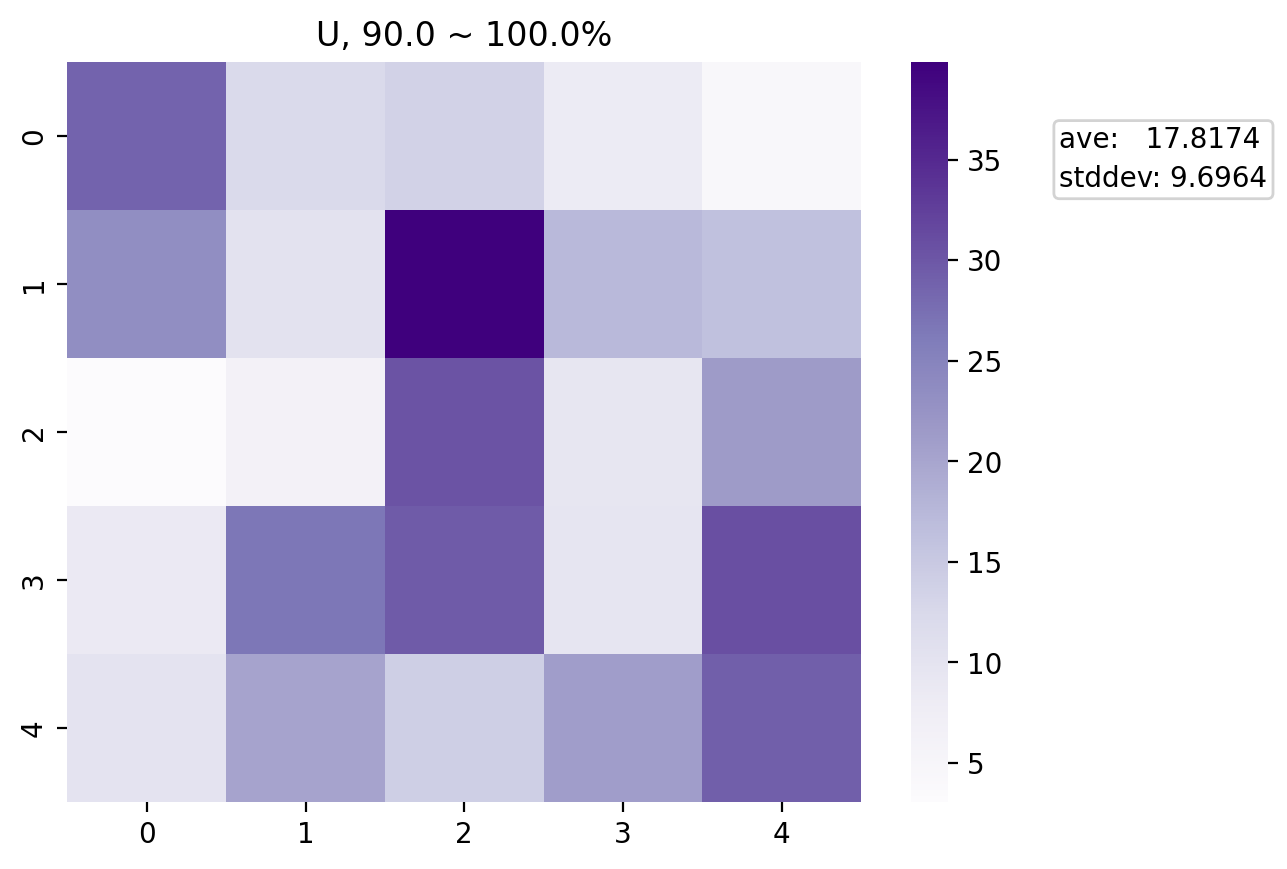

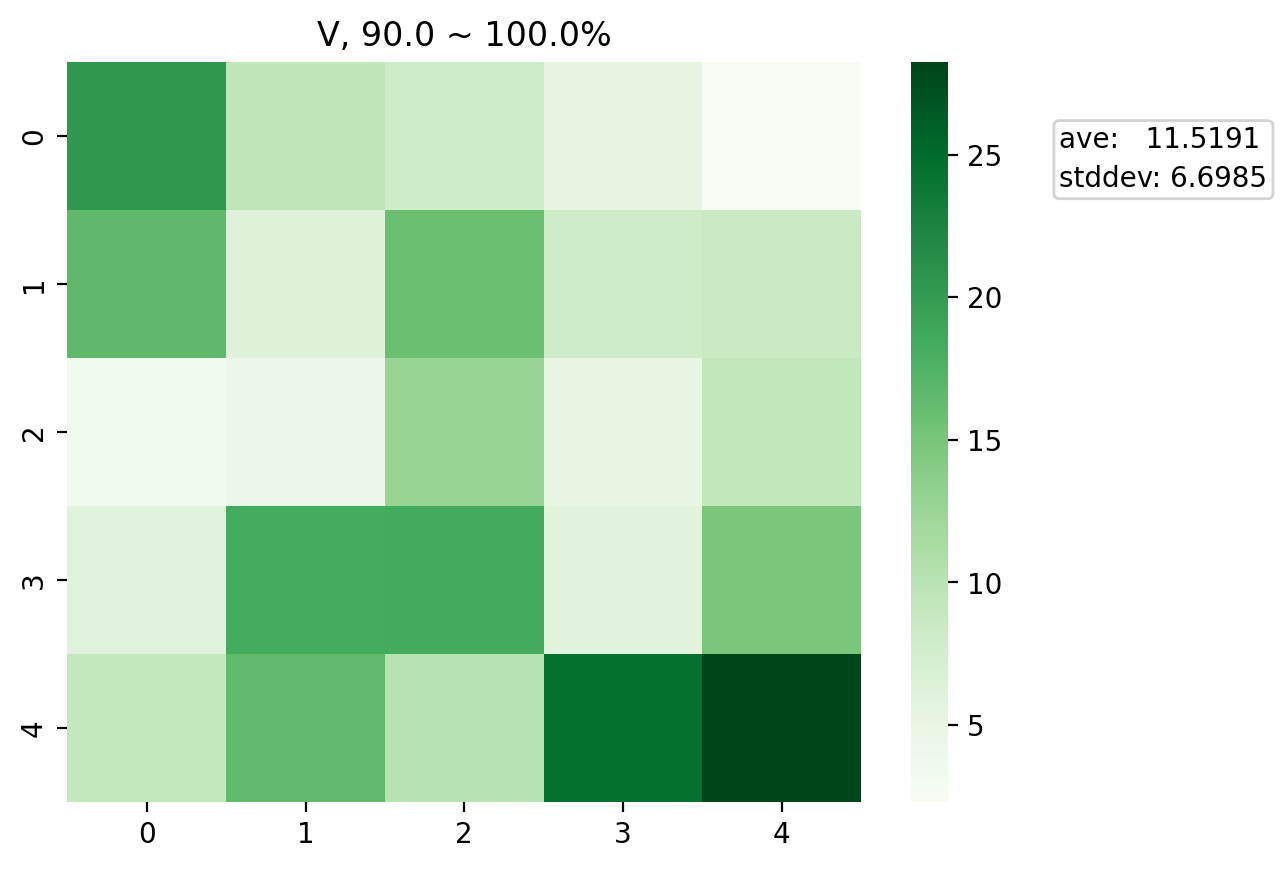

In [70]:
# make some plots
UV_heatmap(sim)

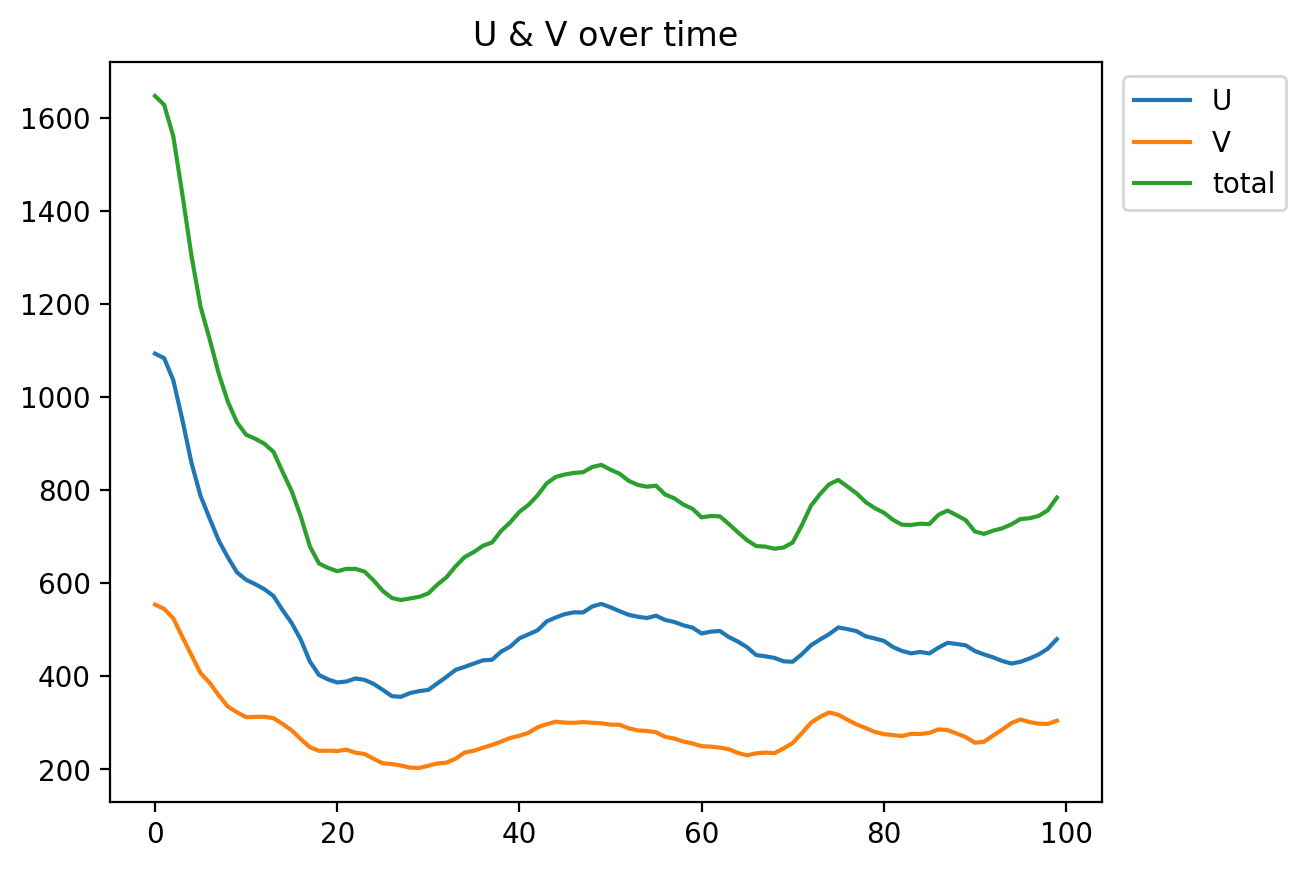

In [71]:
UV_curve(sim)

In [72]:
# use "rfig = True" to return the figure
fig1, fig2 = pi_heatmap(sim, rfig = True)

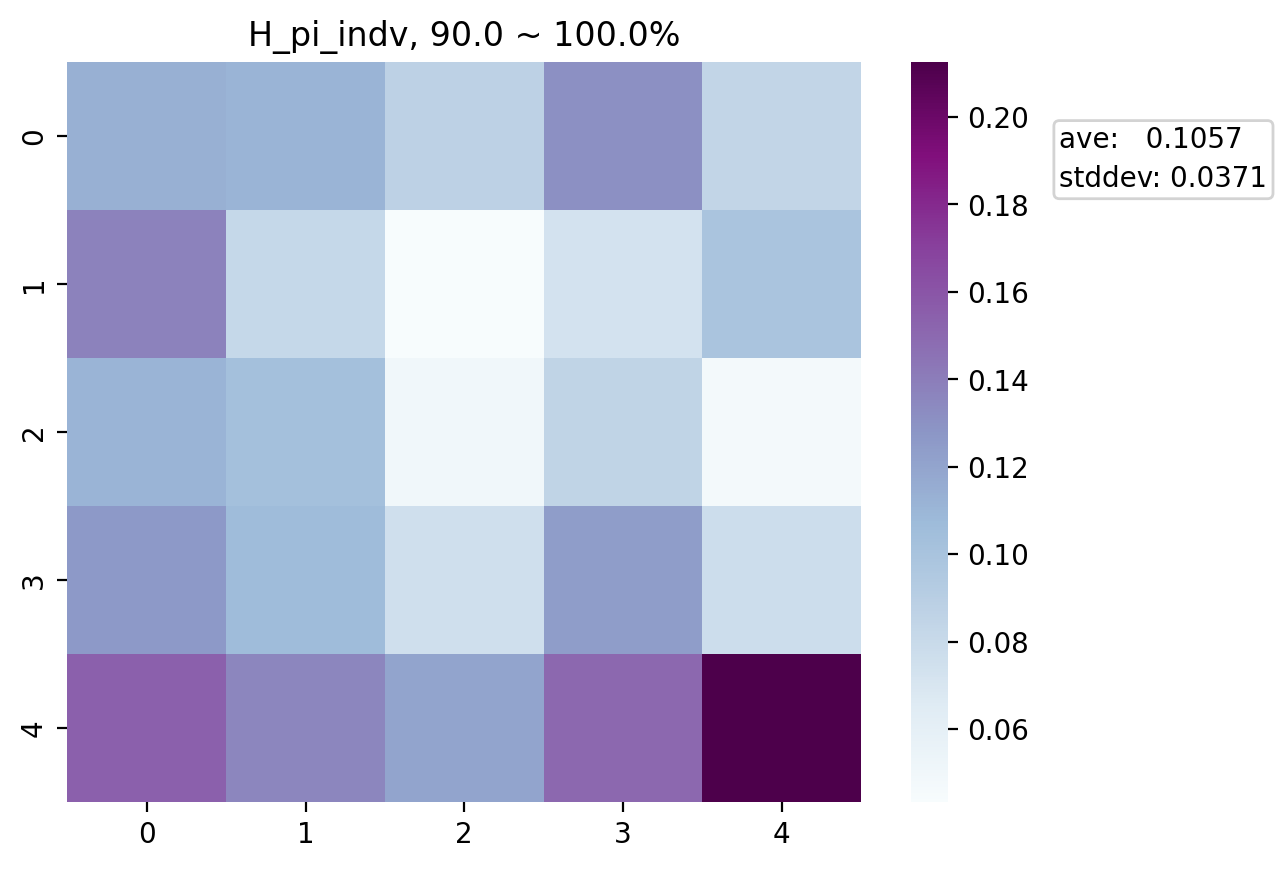

In [73]:
fig1

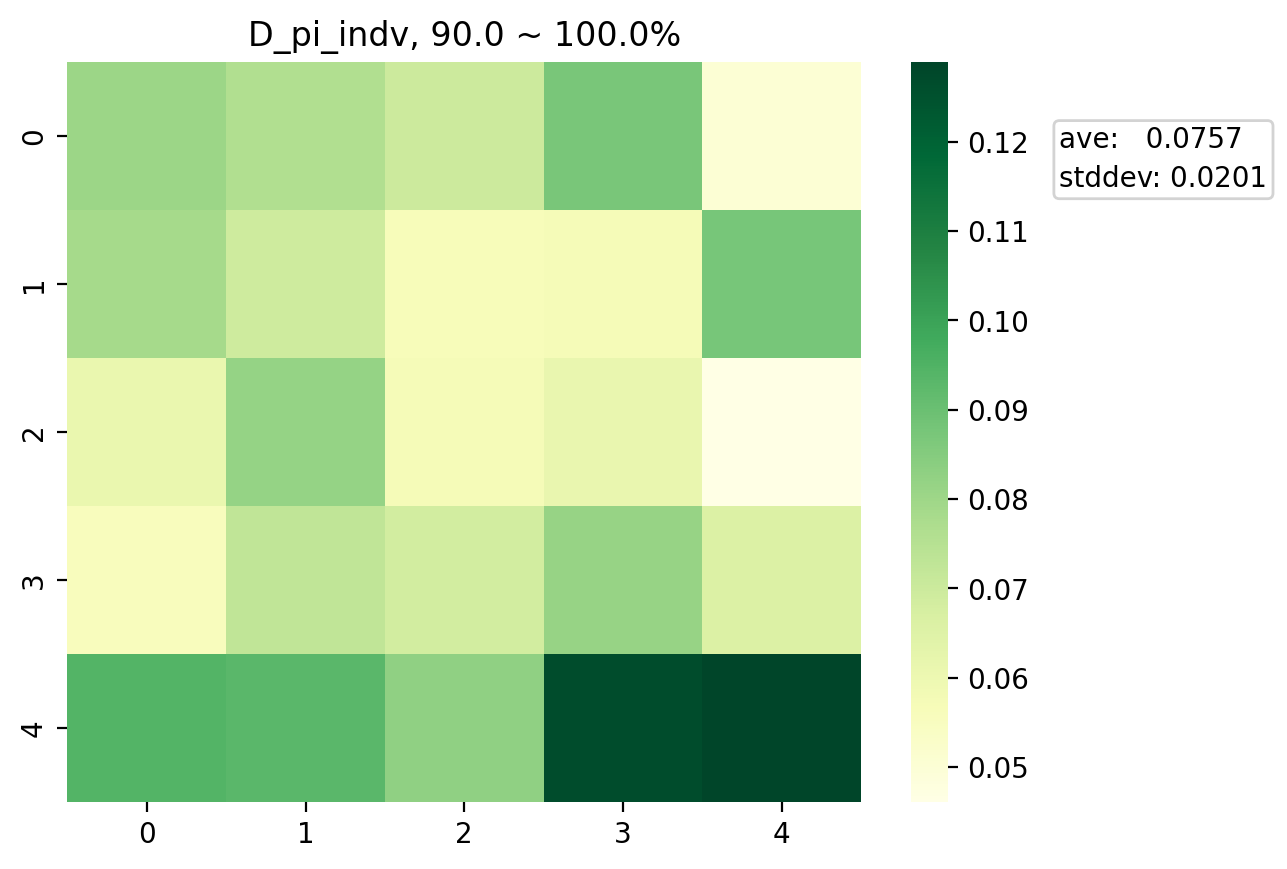

In [74]:
fig2

In [76]:
# make a video!
# and see how the population heatmap changes over time
dirs = "demo folder"
make_video(sim, UV_heatmap, frames = 150, speed = 1, dirs = dirs)

video saved: demo folder      


In [77]:
# you can also make video with other functions
make_video(sim, UV_pi, frames = 150, speed = 1, dirs = dirs)

video saved: demo folder      


In [46]:
# you can also test how a certain variable changes UV & payoff:

var = "mu2"  # we test how mu2 influences payoff
value = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
sims = test_var(sim, var, value)
# note that "sim" is not changed, we made a 6 deep copies of sim to run the simulation
# by using different sim, you can test with different init conditions

runtime: 9.38 s  
runtime: 9.6 s   
runtime: 8.87 s  
runtime: 9.25 s  
runtime: 8.99 s  
runtime: 8.6 s   


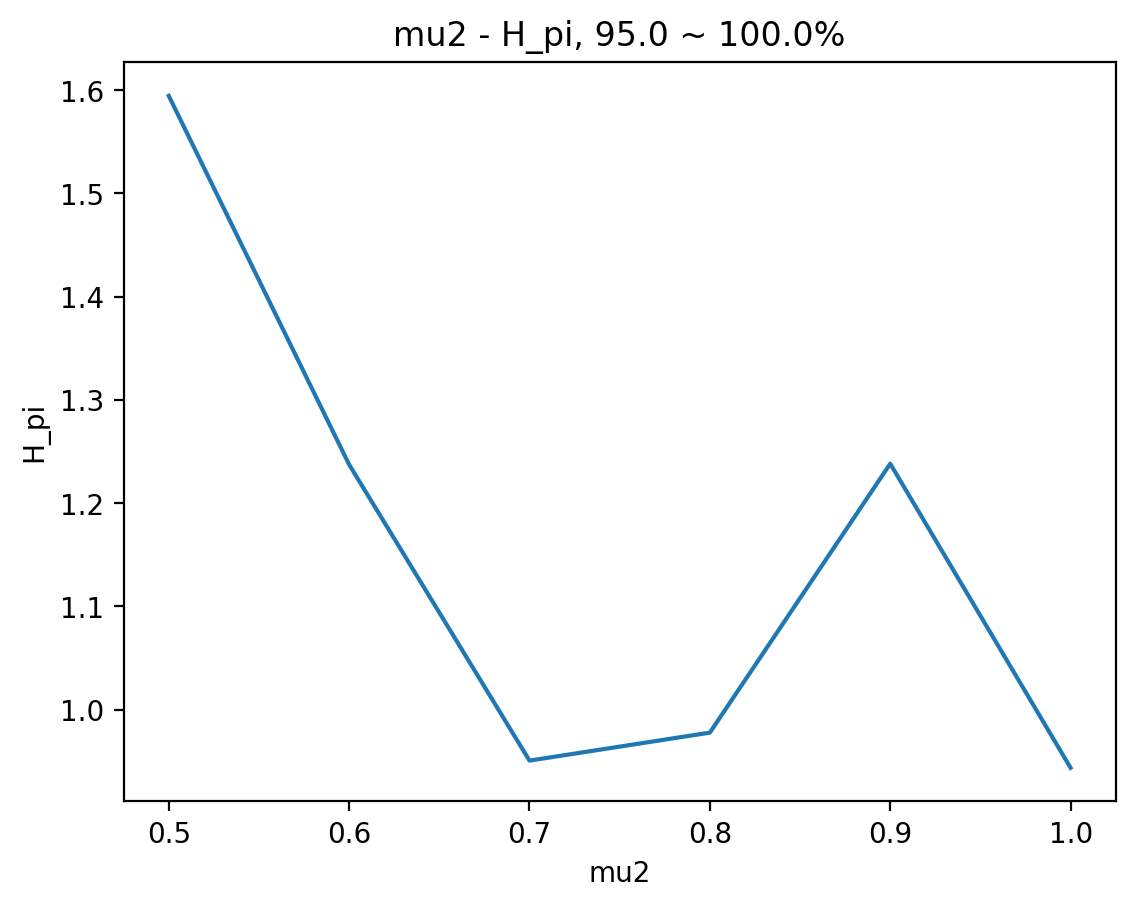

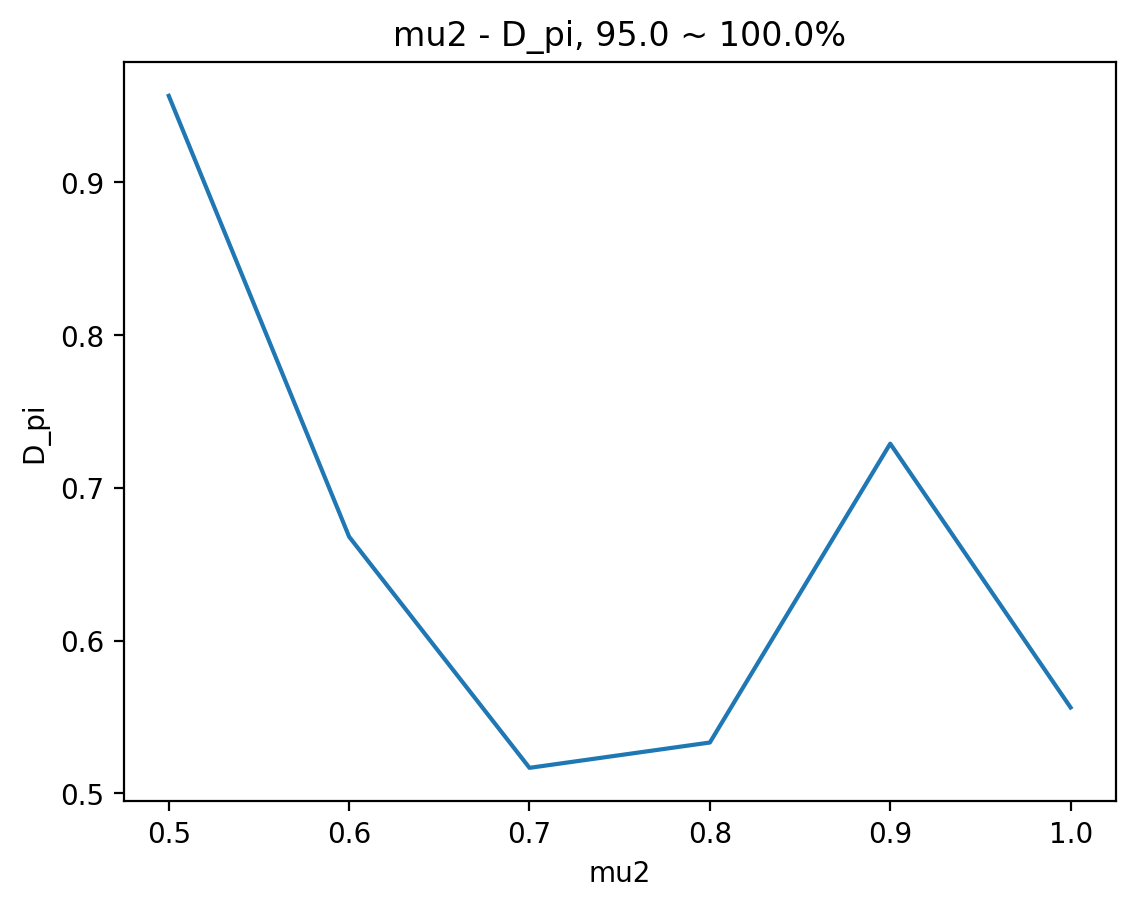

In [55]:
# let's see how mu2 changes payoff
# "indv" means "per-individual payoff", we divide the payoff of every patch by its population (U or V)
var_pi(sims, indv = False)

In [78]:
# save data
save_data(sim, dirs)

data saved: demo folder/data.json.gz


In [79]:
# read data
sim_copy = read_data(dirs)

# you can check sim == sim_copy:
print(sim.N, sim_copy.N)
print(sim.maxtime, sim_copy.maxtime)

5 5
200 200


In [80]:
# use "to_py()" to turn this .ipnb to a .py file, saved in root directory
to_py()

converted: f1_2.py


In [81]:
# auto-generate a runner file:
py_runner()

runner file generated: run_f1_2.py


In [ ]:
# Try other things!